In [2]:
import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
from rdkit.Chem import AllChem


feature_list =['Reagent1 (ul)', 'Reagent2 (ul)', 'Reagent3 (ul)', 'Reagent4 (ul)', 'lab_code']
methods = ['ABC','PSO','Random']
GT_data = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/datasets/combined_compiledData.csv')

ABC = []
PSO = []
Random = []

# 讀取 data1.csv 到 data10.csv
for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC.append(df[10:])
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO.append(df[10:])

    if method =='Random':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            Random.append(df[10:])


# 合併成一個大 DataFrame
ABC = pd.concat(ABC, ignore_index=True)
PSO = pd.concat(PSO, ignore_index=True)
Random = pd.concat(Random, ignore_index=True)

# 從SMILES生成Morgan fingerprints
ABCfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC['SMILES']]
PSOfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO['SMILES']]
Randomfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in Random['SMILES']]
GTfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in GT_data['SMILES']]


ABC_fp_array = np.array([list(fp) for fp in ABCfingerprints])
PSO_fp_array = np.array([list(fp) for fp in PSOfingerprints])
Random_fp_array = np.array([list(fp) for fp in Randomfingerprints])
GT_fp_array = np.array([list(fp) for fp in GTfingerprints])

fp_array = np.concatenate((ABC_fp_array, PSO_fp_array,Random_fp_array,GT_data), axis=0)

crystal_size = (pd.concat([ABC, PSO, Random, GT_data], ignore_index=True))[['crystal_size']]

#print(latent)
print(crystal_size)

ABC = ABC[feature_list]
PSO = PSO[feature_list]
Random = Random[feature_list]
GT_data = GT_data[feature_list]


      crystal_size
0         1.906324
1         1.671430
2         1.341401
3         1.118565
4         1.056210
...            ...
1495      1.837591
1496      1.543171
1497      1.517777
1498      1.425842
1499      1.398253

[1500 rows x 1 columns]


/tmp/ipykernel_44375/1731003631.py:1: DeprecationWarning: Accessing jsonschema.draft3_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft3_format_checker
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_44375/1731003631.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

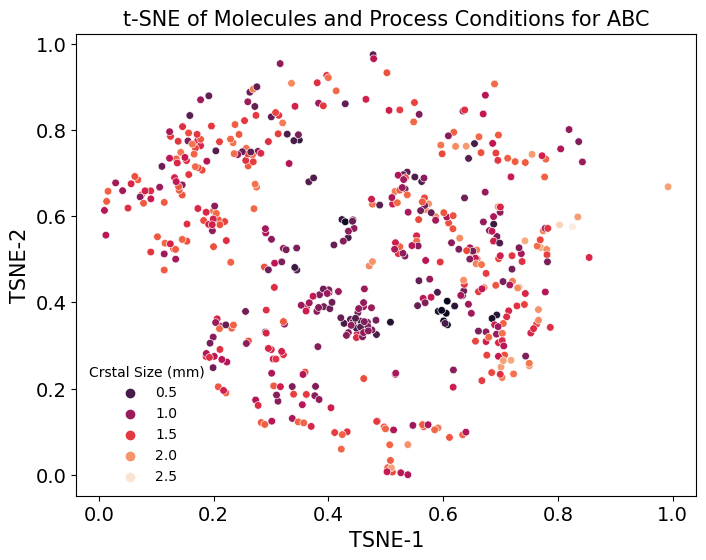

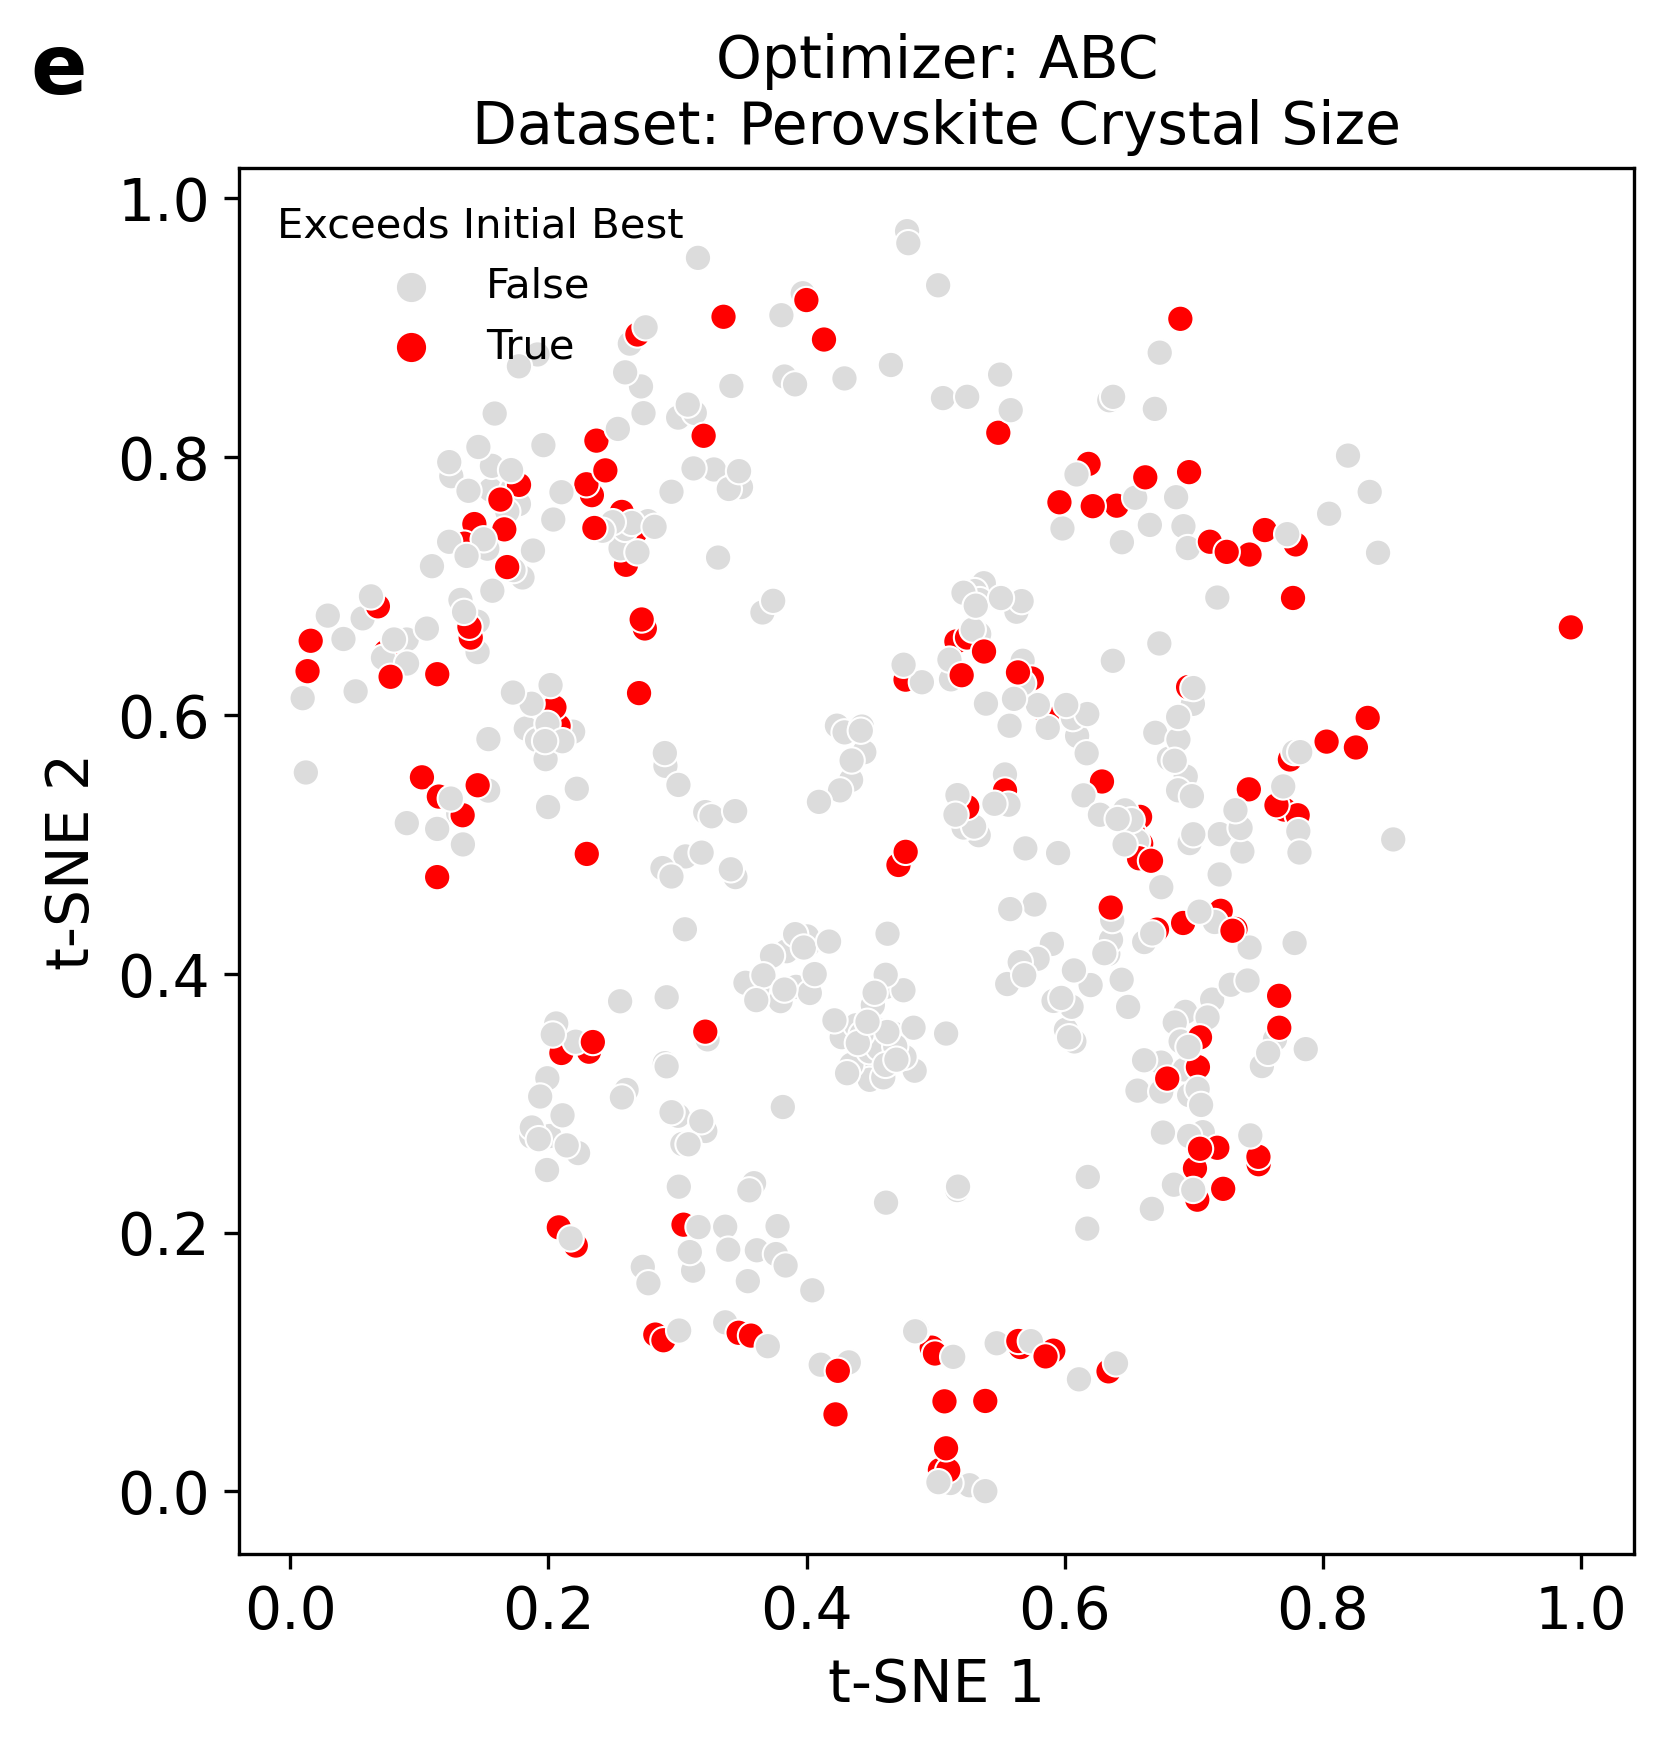

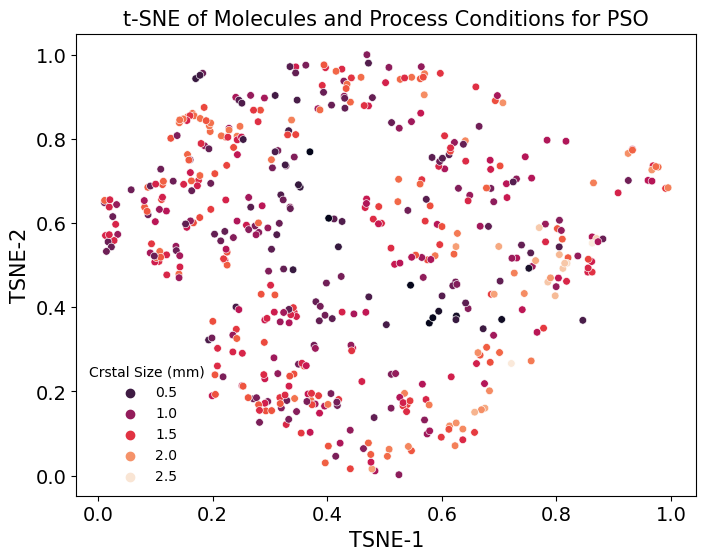

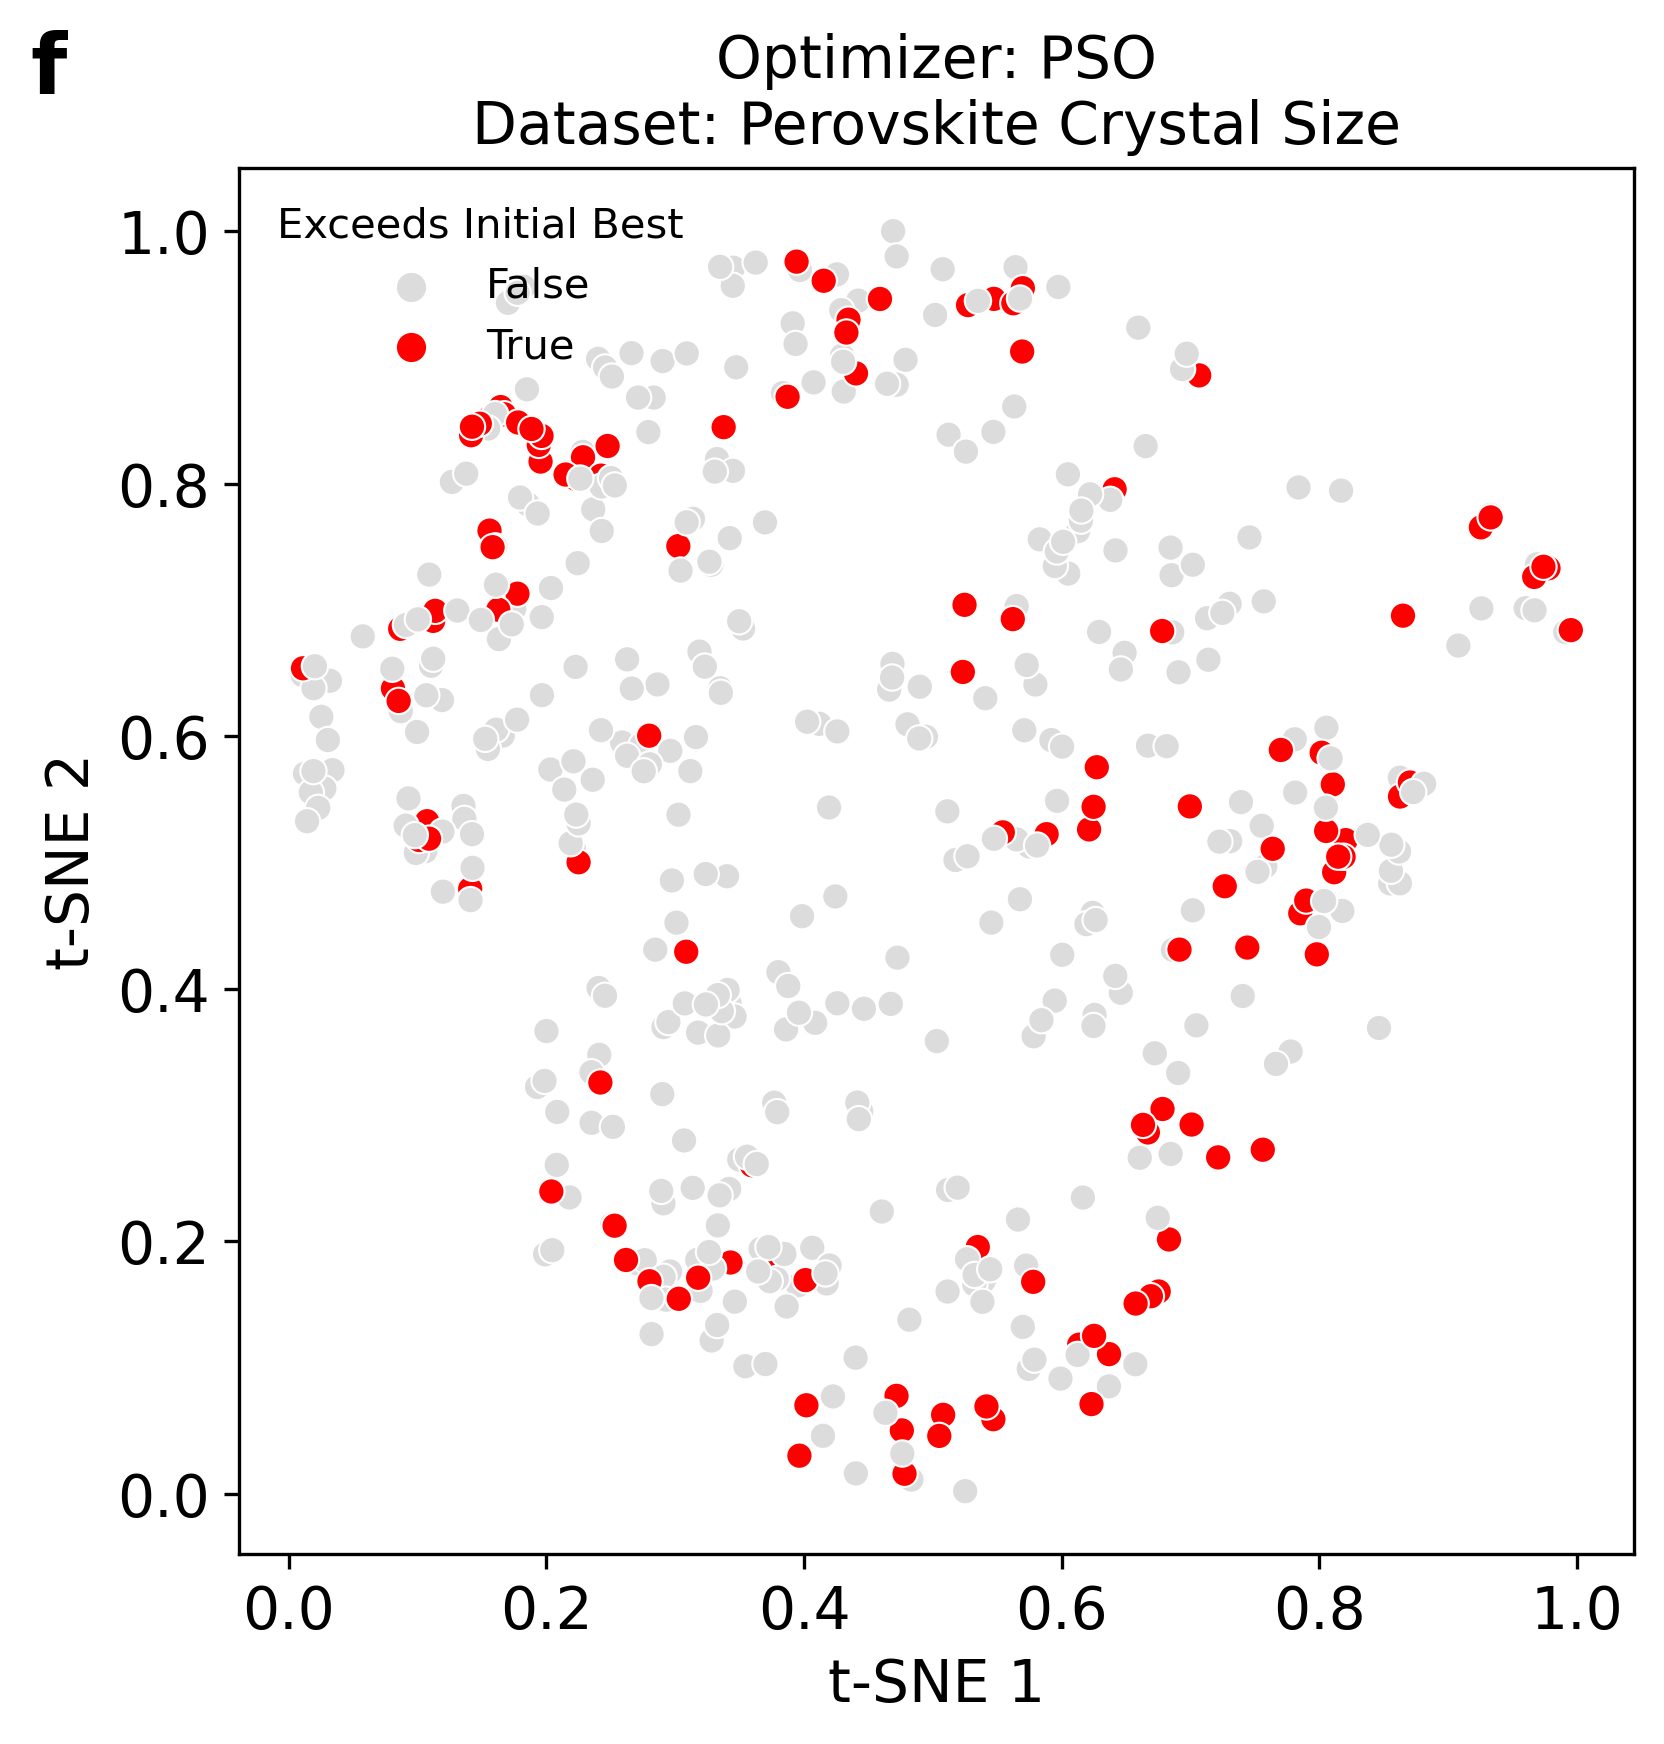

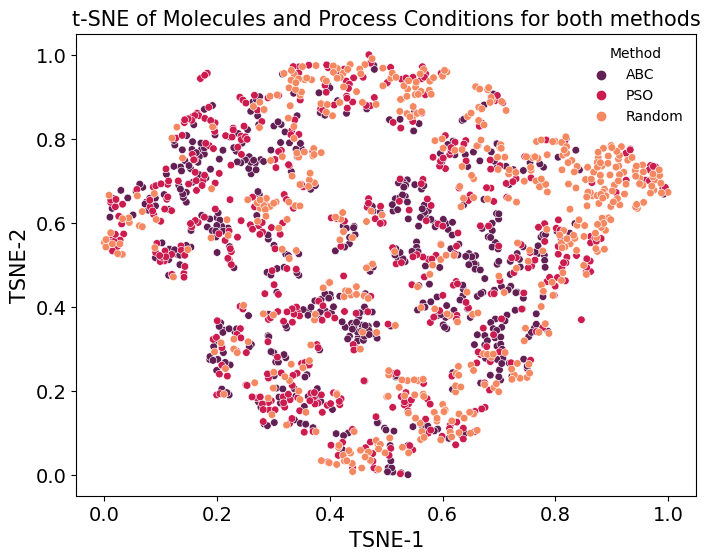

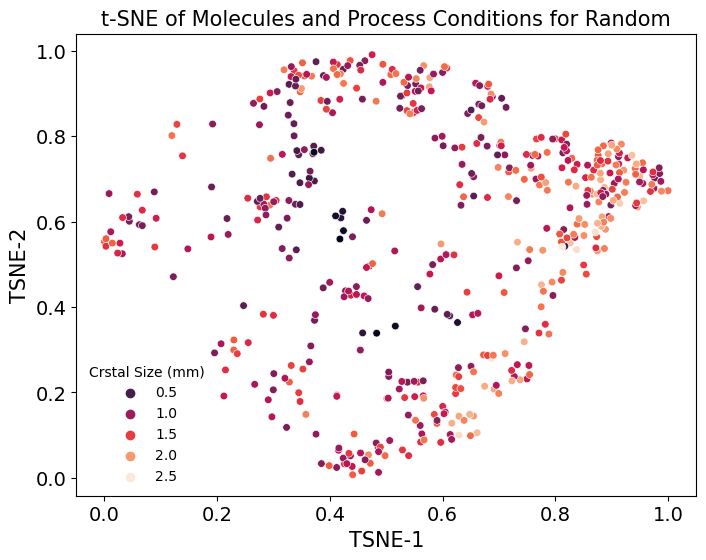

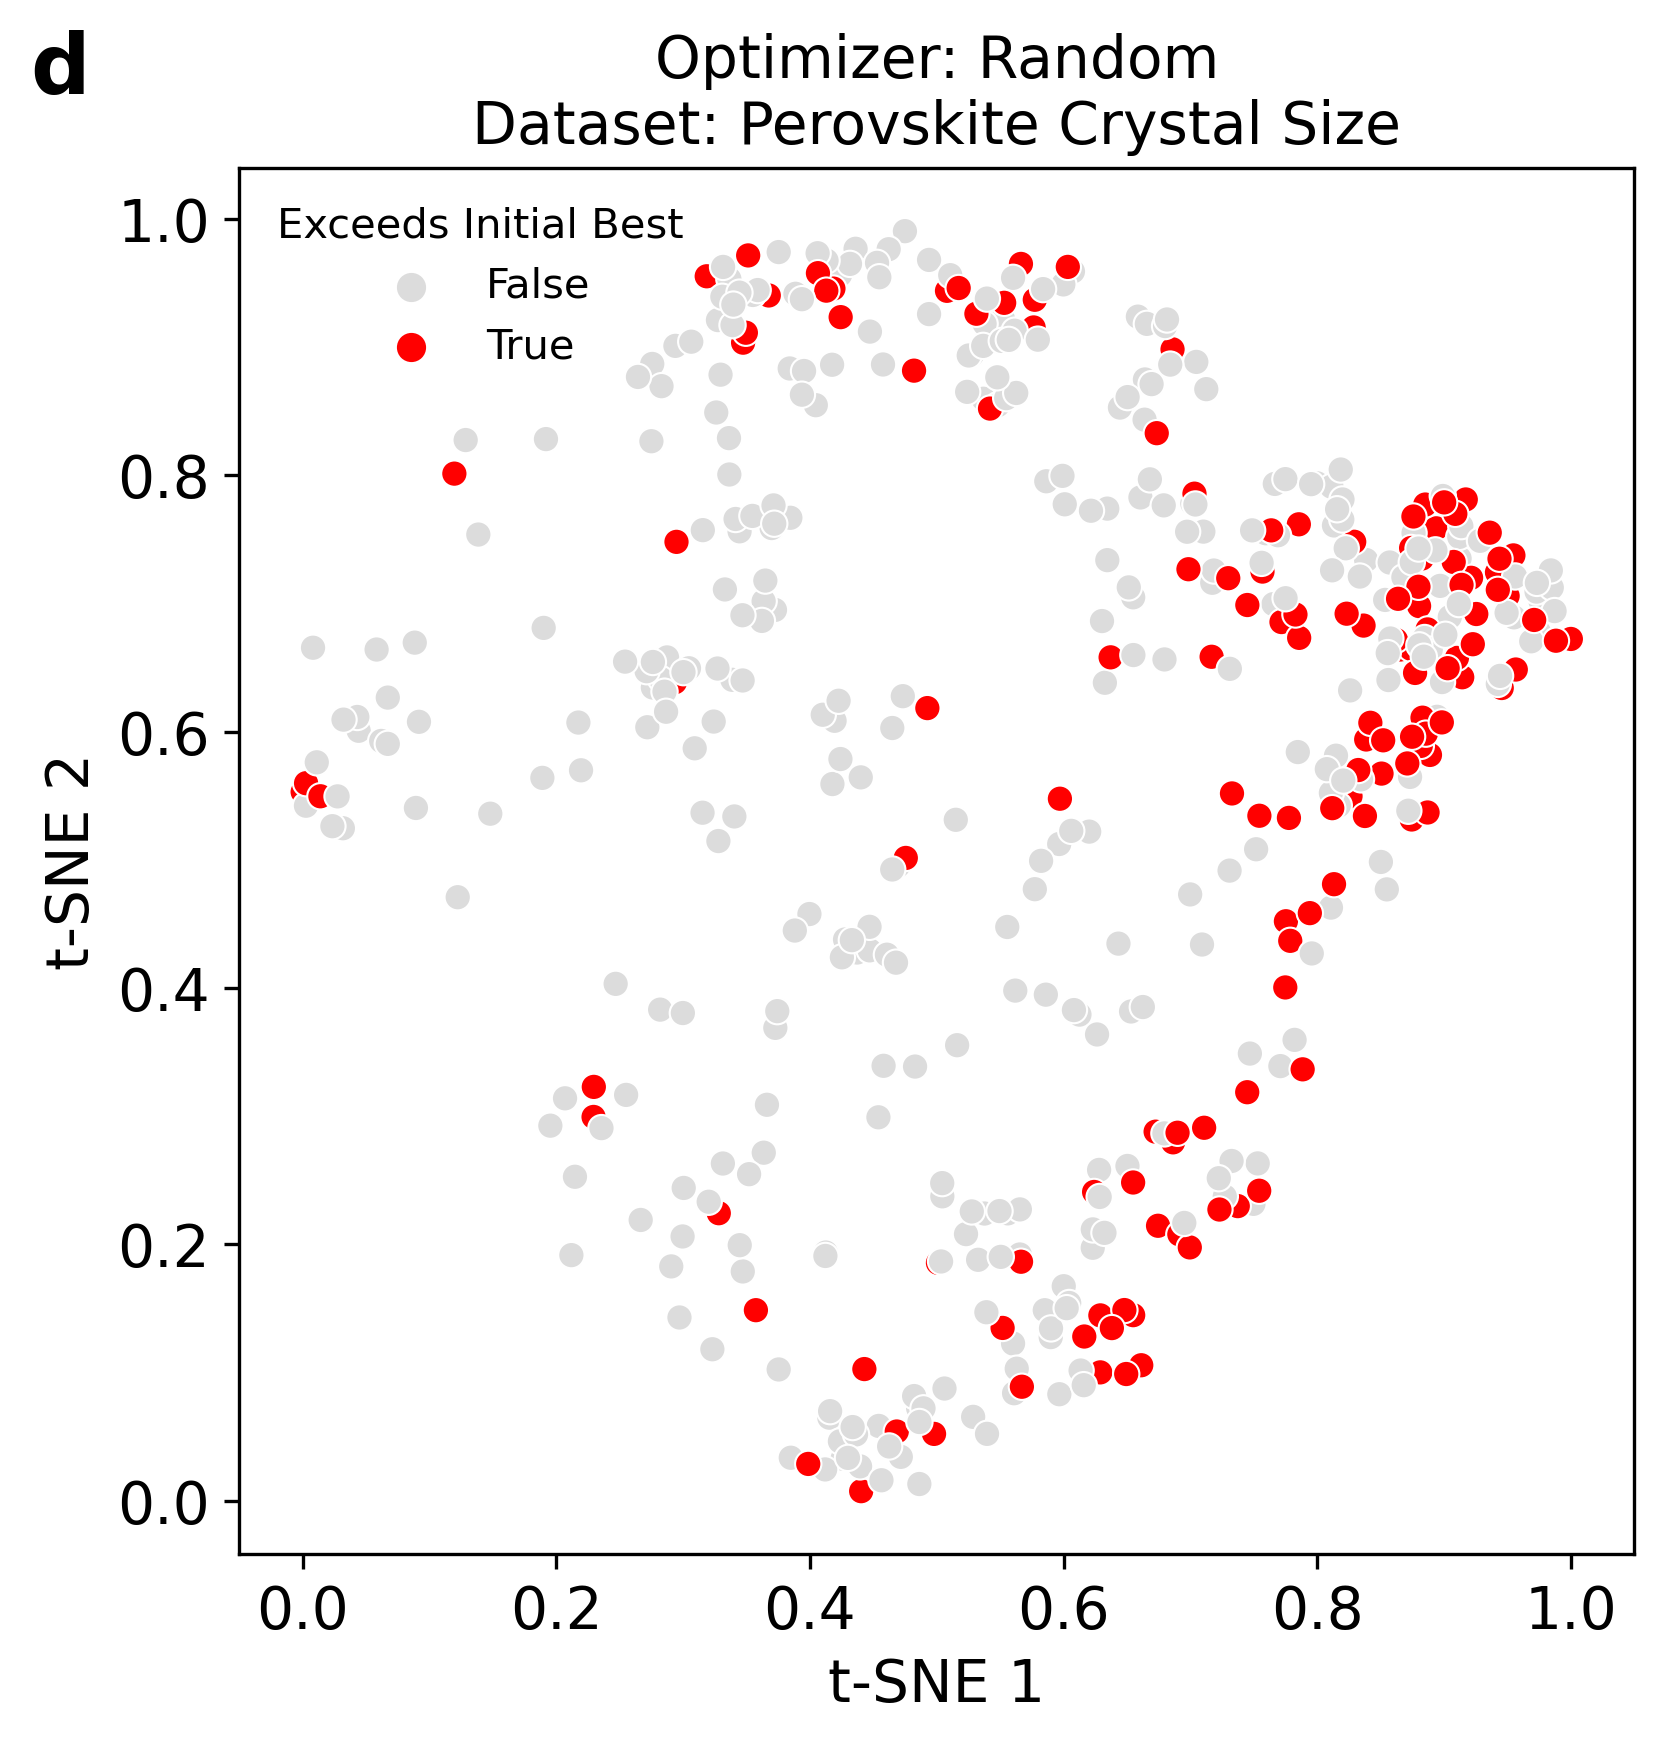

In [3]:
from jsonschema import draft3_format_checker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler

#first combine without latent
c_df = pd.concat([ABC, PSO,Random], ignore_index=True)
#c_df = data2

c_df = c_df.values
c_df = np.concatenate((c_df, fp_array), axis=1)
#c_df = latent

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(c_df)

# Normalize the t-SNE values
scaler = MinMaxScaler()
tsne_results_normalized = scaler.fit_transform(tsne_results)


# Add a column to indicate the dataset
ABC['dataset'] = 'ABC'
PSO['dataset'] = 'PSO'
Random['dataset'] = 'Random'

ABC['crystal_size'] = crystal_size.iloc[:500].values
PSO['crystal_size'] = crystal_size.iloc[500:1000].values
Random['crystal_size'] = crystal_size.iloc[1000:1500].values

# Combine the datasets
combined_df = pd.concat([ABC, PSO, Random], ignore_index=True)
#combined_df = data2

# Add normalized t-SNE results to the DataFrame
combined_df['TSNE-1'] = tsne_results_normalized[:, 0]
combined_df['TSNE-2'] = tsne_results_normalized[:, 1]

df1 = combined_df.iloc[:500]
df2 = combined_df.iloc[500:1000]
df3 = combined_df.iloc[1000:1500]

threshold = 1.66
threshold2 = 1.76
threshold3 = 1.86
threshold4 = 1.96

df1['group'] = df1['crystal_size'] > threshold  # 產生布林值欄位
df2['group'] = df2['crystal_size'] > threshold  # 產生布林值欄位
df3['group'] = df3['crystal_size'] > threshold  # 產生布林值欄位

df1['group2'] = df1['crystal_size'] > threshold2  # 產生布林值欄位
df2['group2'] = df2['crystal_size'] > threshold2  # 產生布林值欄位
df3['group2'] = df3['crystal_size'] > threshold2  # 產生布林值欄位

df1['group3'] = df1['crystal_size'] > threshold3  # 產生布林值欄位
df2['group3'] = df2['crystal_size'] > threshold3  # 產生布林值欄位
df3['group3'] = df3['crystal_size'] > threshold3  # 產生布林值欄位

df1['group4'] = df1['crystal_size'] > threshold4  # 產生布林值欄位
df2['group4'] = df2['crystal_size'] > threshold4  # 產生布林值欄位
df3['group4'] = df3['crystal_size'] > threshold4  # 產生布林值欄位

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'crystal_size', palette='rocket',data=df1, s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for ABC', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon = False, title='Crstal Size (mm)')
plt.show()

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'group', data=df1, palette={True: 'red', False: '#DCDCDC'},s=40)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.text(-0.15, 1.1, 'e',
        transform=ax.transAxes,
        fontsize=20, fontweight='bold',
        va='top', ha='left')


plt.title('Optimizer: ABC\nDataset: Perovskite Crystal Size', fontsize=14)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.legend(frameon=False, title='Exceeds Initial Best', loc = 'upper left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/ABCPvk.jpeg')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'crystal_size', data=df2, palette='rocket',s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for PSO', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon=False, title='Crstal Size (mm)')
plt.show()

# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'group', data=df2, palette={True: 'red', False: '#DCDCDC'},s=40)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.text(-0.15, 1.1, 'f',
        transform=ax.transAxes,
        fontsize=20, fontweight='bold',
        va='top', ha='left')


plt.title('Optimizer: PSO\nDataset: Perovskite Crystal Size', fontsize=14)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.legend(frameon=False, title='Exceeds Initial Best', loc = 'upper left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/PSOPvk.jpeg')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'dataset', data=combined_df, palette='rocket',s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for both methods', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon=False, title='Method')
plt.show()

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'crystal_size', palette='rocket',data=df3, s=30)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('t-SNE of Molecules and Process Conditions for Random', fontsize=15)
plt.xlabel('TSNE-1', fontsize = 15)
plt.ylabel('TSNE-2', fontsize = 15)
plt.legend(frameon = False, title='Crstal Size (mm)')
plt.show()

# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
sns.scatterplot(x='TSNE-1', y='TSNE-2', hue = 'group', data=df3, palette={True: 'red', False: '#DCDCDC'},s=40)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax.text(-0.15, 1.1, 'd',
        transform=ax.transAxes,
        fontsize=20, fontweight='bold',
        va='top', ha='left')


plt.title('Optimizer: Random\nDataset: Perovskite Crystal Size', fontsize=14)
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.legend(frameon=False, title='Exceeds Initial Best', loc = 'upper left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/RandomPvk.jpeg')
plt.show()

Text(0.5, 1.0, 't-SNE comparison of exploration: PSO vs ABC')

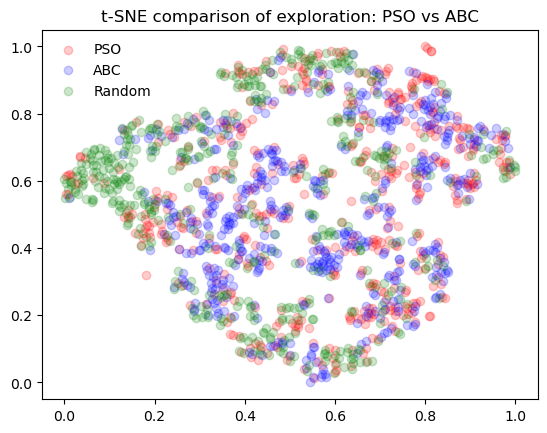

In [6]:
plt.scatter(x=df2['TSNE-1'], y=df2['TSNE-2'],color='red', alpha=0.2, label='PSO')
plt.scatter(x=df1['TSNE-1'], y=df1['TSNE-2'], color='blue', alpha=0.2, label='ABC')
plt.scatter(x=df3['TSNE-1'], y=df3['TSNE-2'], color='green', alpha=0.2, label='Random')
plt.legend(frameon = False)
plt.title('t-SNE comparison of exploration: PSO vs ABC')

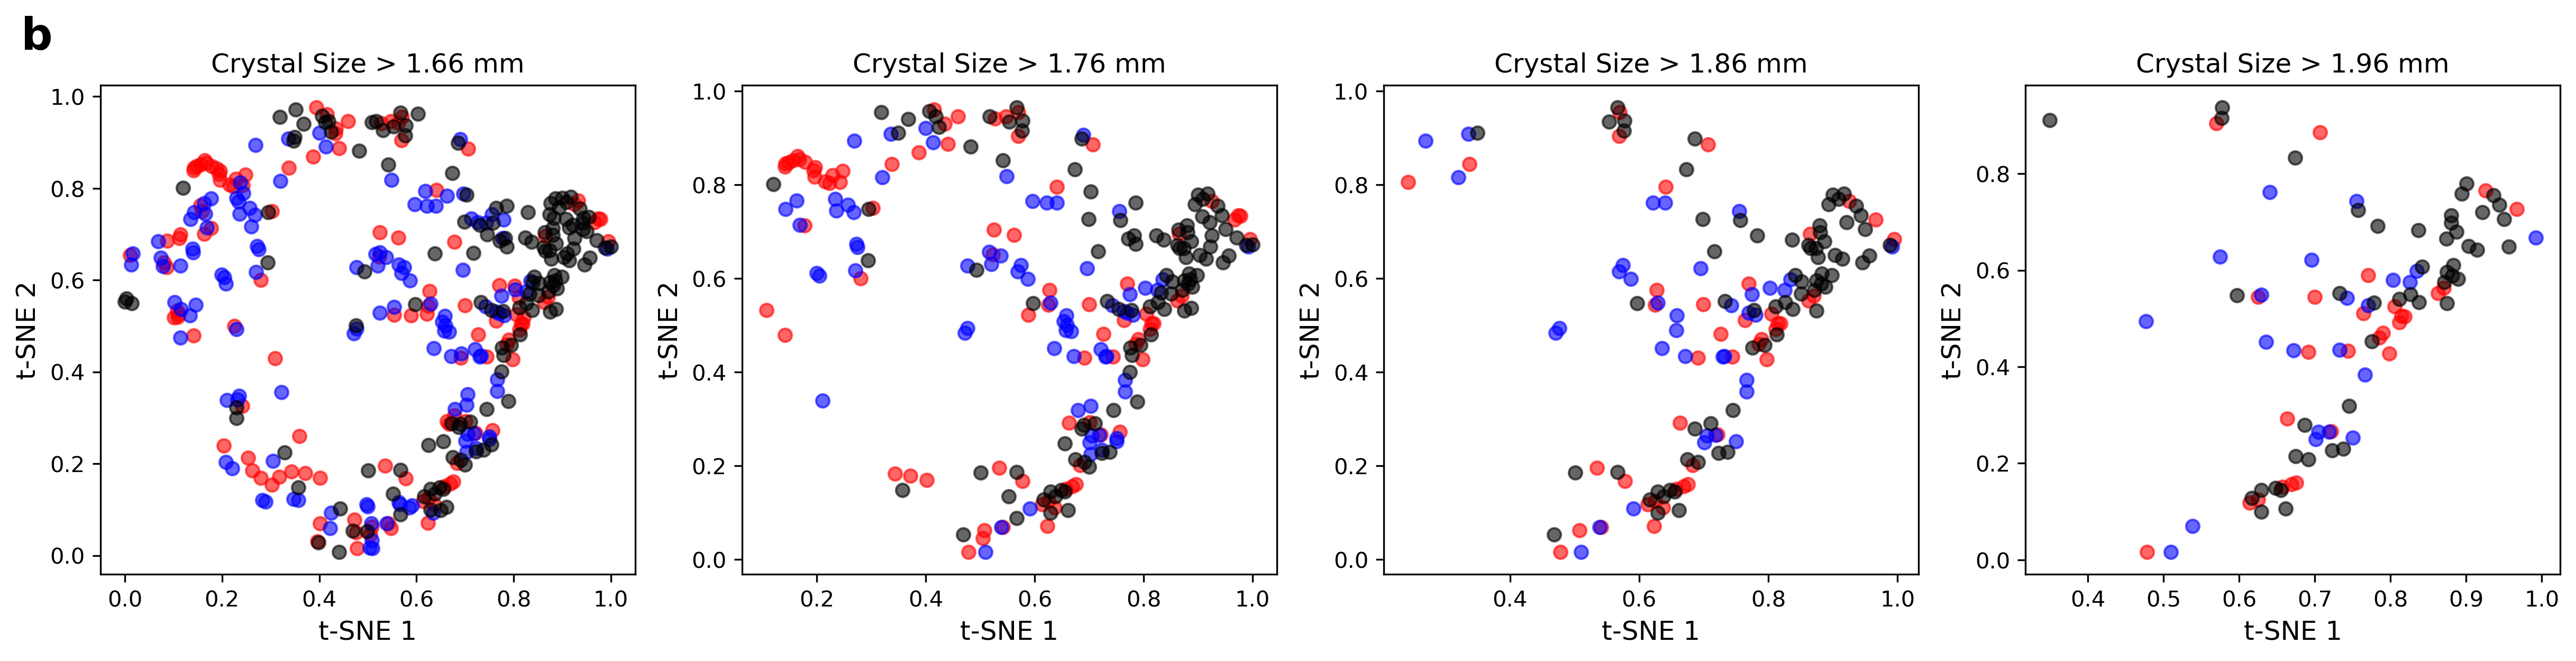

In [4]:
groups = ['group', 'group2','group3','group4']
nums = {'group':0, 'group2':1, 'group3':2, 'group4':3}
names = {'group':'1.66', 'group2':'1.76', 'group3':'1.86', 'group4':'1.96'}

fig, ax = plt.subplots(1, 4, figsize=(20, 4), dpi=300)

for group in groups:
    num = nums[group]
    name = names[group]
    
    ABC_cut = df1[df1[group]][['TSNE-1', 'TSNE-2']]
    PSO_cut = df2[df2[group]][['TSNE-1', 'TSNE-2']]
    random_cut = df3[df3[group]][['TSNE-1', 'TSNE-2']]
    ax[num].set_xlabel('t-SNE 1', fontsize = 12)
    ax[num].set_ylabel('t-SNE 2', fontsize = 12)
    ax[num].scatter(x=PSO_cut['TSNE-1'], y=PSO_cut['TSNE-2'],color='red', alpha=0.6, label='PSO')
    ax[num].scatter(x=ABC_cut['TSNE-1'], y=ABC_cut['TSNE-2'], color='blue', alpha=0.6, label='ABC')
    ax[num].scatter(x=random_cut['TSNE-1'], y=random_cut['TSNE-2'], color='black', alpha=0.6, label='Random')
    #ax[num].legend(frameon = False, loc = 'upper left', fontsize = 10)
    ax[num].set_title('Crystal Size > '+name+" mm")

fig.text(0.1, 0.99, 'b', fontsize=20, fontweight='bold',
         va='top', ha='left')
plt.savefig('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/AllPvktsne.jpeg')

In [58]:
#合併圖片

from PIL import Image

# 讀入三張圖（確保路徑正確）
img1 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/AllPvktsne.jpeg")
img2 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/AllAryltsne.jpeg")

# 假設三張圖大小相同，取得寬高
width, height = img1.size

# 建立新圖像，寬度為三倍，垂直高度不變
new_img = Image.new('RGB', (width, height*2))

# 將三張圖貼上去
new_img.paste(img2, (0, 0))
new_img.paste(img1, (0, height))
new_img.save('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/AllPvkAryltsne.jpeg')

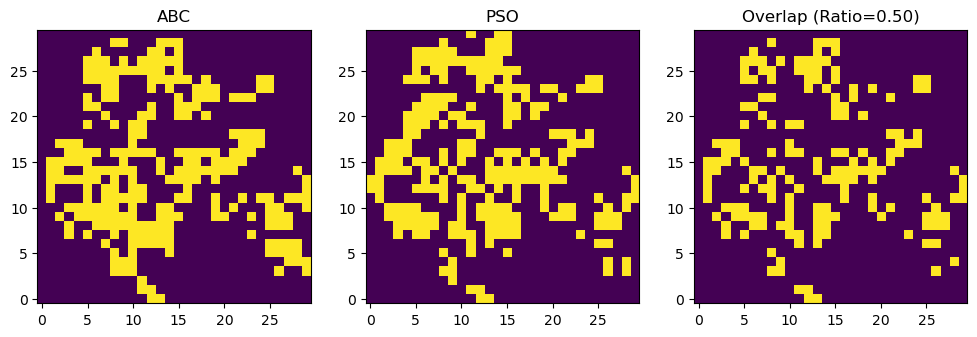

Overlap Ratio: 0.504


In [43]:
import numpy as np

def compute_overlap_ratio(x1, y1, x2, y2, bins=100, plot=False):
    """
    Compute the overlap ratio between two sets of points on t-SNE (or any 2D space).
    
    Args:
        x1, y1: np.ndarray, first method's points
        x2, y2: np.ndarray, second method's points
        bins: int, number of bins per axis for discretization
        plot: bool, if True, plot the occupancy grids for visual confirmation
        
    Returns:
        overlap_ratio: float, between 0 and 1
    """
    # Combine data to get global min/max for consistent binning
    all_x = np.concatenate([x1, x2])
    all_y = np.concatenate([y1, y2])

    # Create 2D histograms as occupancy grids
    H1, xedges, yedges = np.histogram2d(x1, y1, bins=bins, range=[[all_x.min(), all_x.max()], [all_y.min(), all_y.max()]])
    H2, _, _ = np.histogram2d(x2, y2, bins=[xedges, yedges])
    
    # Convert to boolean occupancy (occupied = 1)
    mask1 = H1 > 0
    mask2 = H2 > 0

    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    overlap_ratio = intersection / union if union > 0 else 0.0

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(mask1.T, origin='lower')
        plt.title('ABC')
        plt.subplot(1, 3, 2)
        plt.imshow(mask2.T, origin='lower')
        plt.title('PSO')
        plt.subplot(1, 3, 3)
        plt.imshow(np.logical_and(mask1, mask2).T, origin='lower')
        plt.title(f'Overlap (Ratio={overlap_ratio:.2f})')
        plt.show()
    
    return overlap_ratio

ratio = compute_overlap_ratio(x2=df2['TSNE-1'], y2=df2['TSNE-2'], x1=df1['TSNE-1'], y1=df1['TSNE-2'], bins=50, plot=True)
print(f'Overlap Ratio: {ratio:.3f}')

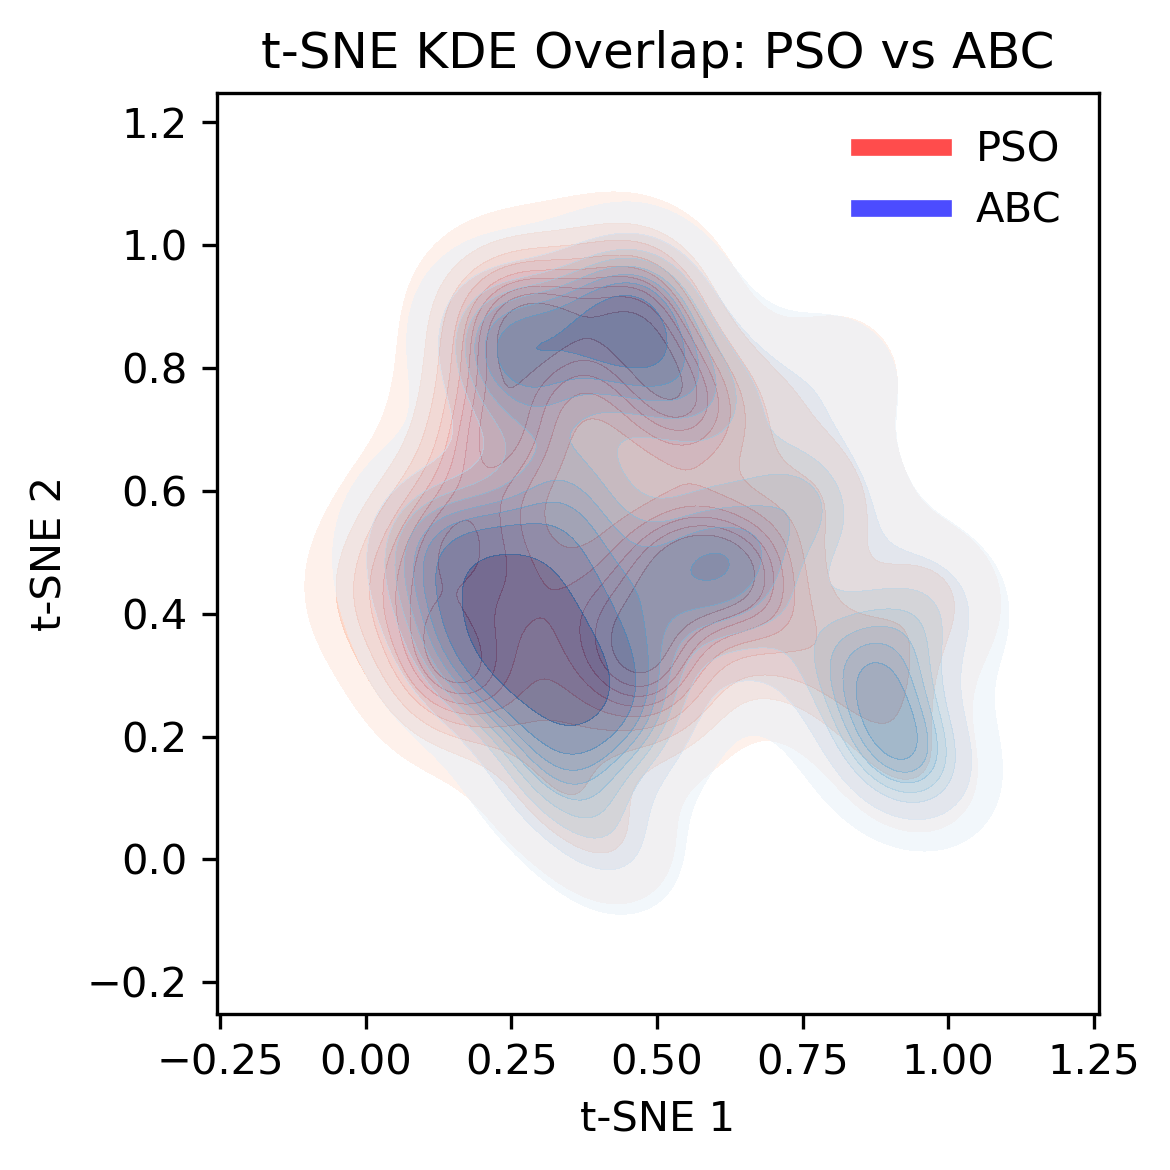

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_kde_with_overlap(x_pso, y_pso, x_abc, y_abc, bins=100):
    plt.figure(figsize=(4, 4), dpi = 300)

    # KDE plot for PSO
    sns.kdeplot(
        x=x_pso, y=y_pso,
        fill=True,
        cmap='Reds',
        alpha=0.5,
        thresh=0.05,
        label='PSO'
    )

    # KDE plot for ABC
    sns.kdeplot(
        x=x_abc, y=y_abc,
        fill=True,
        cmap='Blues',
        alpha=0.5,
        thresh=0.05,
        label='ABC'
    )

    # Adding scatter for reference if needed
    # plt.scatter(x_pso, y_pso, color='red', alpha=0.1, s=10)
    # plt.scatter(x_abc, y_abc, color='blue', alpha=0.1, s=10)

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE KDE Overlap: PSO vs ABC')

    # Add legend manually
    red_patch = plt.Line2D([0], [0], color='red', lw=4, alpha=0.7, label='PSO')
    blue_patch = plt.Line2D([0], [0], color='blue', lw=4, alpha=0.7, label='ABC')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right', frameon=False)

    plt.tight_layout()
    plt.show()

plot_tsne_kde_with_overlap(df2['TSNE-1'],df2['TSNE-2'], df1['TSNE-1'], df1['TSNE-2'])

In [1]:
#合併圖片

from PIL import Image

# 讀入三張圖（確保路徑正確）
img1 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/ABCPvk.jpeg")
img2 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/PSOPvk.jpeg")
img3 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/RandomPvk.jpeg")

# 假設三張圖大小相同，取得寬高
width, height = img1.size

# 建立新圖像，寬度為三倍，垂直高度不變
new_img = Image.new('RGB', (width * 3, height))

# 將三張圖貼上去
new_img.paste(img3, (0, 0))
new_img.paste(img1, (width, 0))
new_img.paste(img2, (2 * width, 0))

# 儲存或顯示
new_img.save("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/results_tsne.jpeg")
new_img.show()

img4 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/results_tsne.jpeg")
img5 = Image.open("/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/4_Final_Anslysis_Like_EDBO/results_tsne.jpeg")

# 假設三張圖大小相同，取得寬高
width, height = img4.size

# 建立新圖像，寬度為三倍，垂直高度不變
new_img = Image.new('RGB', (width , height*2))

# 將三張圖貼上去
new_img.paste(img5, (0, 0))
new_img.paste(img4, (0, height))

# 儲存或顯示
new_img.save("/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/4_Final_Anslysis_Like_EDBO/results_tsne_combined.jpeg")
new_img.show()




(eog:59683): Gtk-WARNING **: 23:56:11.796: cannot open display: 



(eog:59693): Gtk-WARNING **: 23:56:12.919: cannot open display: 


In [30]:
# Chemical Space analysis
import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
from rdkit.Chem import AllChem
from jsonschema import draft3_format_checker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler

ABC_pvk = []
PSO_pvk = []
ABC_ary = []
PSO_ary = []

methods  = ['ABC','PSO']

# 讀取 data1.csv 到 data10.csv
for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC_pvk.append(df)
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO_pvk.append(df)

for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC_ary.append(df)
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO_ary.append(df)

# 合併成一個大 DataFrame
PSO_pvk = pd.concat(PSO_pvk, ignore_index=True)
PSO_ary = pd.concat(PSO_ary, ignore_index=True)
ABC_pvk = pd.concat(ABC_pvk, ignore_index=True)
ABC_ary = pd.concat(ABC_ary, ignore_index=True)

# 從SMILES生成Morgan fingerprints
PSOpvkfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO_pvk['SMILES']]
PSOaryfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in PSO_ary['Ligand_SMILES']]
ABCpvkfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC_pvk['SMILES']]
ABCaryfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC_ary['Ligand_SMILES']]

PSOpvk_fp_array = np.array([list(fp) for fp in PSOpvkfingerprints])
PSOary_fp_array = np.array([list(fp) for fp in PSOaryfingerprints])
ABCpvk_fp_array = np.array([list(fp) for fp in ABCpvkfingerprints])
ABCary_fp_array = np.array([list(fp) for fp in ABCaryfingerprints])

fp_array = np.concatenate((PSOpvk_fp_array, PSOary_fp_array, ABCpvk_fp_array, ABCary_fp_array), axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(fp_array)

# Normalize the t-SNE values
scaler = MinMaxScaler()
tsne_results_normalized = scaler.fit_transform(tsne_results)

# 建立分群標籤（共 4 組）
# A: 前600 → 'A_early', A: 後600 → 'A_late'
# B: 前600 → 'B_early', B: 後600 → 'B_late'
labels = ['PSO + Pvk'] * 600 + ['PSO + Ary'] * 600 + ['ABC + Pvk'] * 600 + ['ABC + Ary'] * 600

# 放入 DataFrame 以便繪圖
df = pd.DataFrame(tsne_results_normalized, columns=['x', 'y'])
df['group'] = labels


plt.figure(figsize=(7, 7))
sns.scatterplot(
    data=df,
    x='x', y='y',
    hue='group',
    palette={
        'PSO + Pvk': '#1f77b4',  # 深藍
        'PSO + Ary': '#aec7e8',   # 淺藍
        'ABC + Pvk': '#ff7f0e',  # 深橘
        'ABC + Ary': '#ffbb78'    # 淺橘
    },
    s=50,
    alpha=0.9
)
plt.title("t-SNE Visualization of Two Groups with Early/Late Split")
plt.legend(title='Group & Phase')
plt.tight_layout()
plt.show()


# 假設 df 裡面有 t-SNE 結果和 group（含 A_early, A_late, B_early, B_late）
# 篩選兩組資料
df_A = df[df['group'].isin(['PSO + Pvk', 'PSO + Ary'])]
df_B = df[df['group'].isin(['ABC + Pvk', 'ABC + Ary'])]

# 顏色設定
palette_A = {
    'PSO + Pvk': '#1f77b4',
    'PSO + Ary': '#aec7e8'
}
palette_B = {
    'ABC + Pvk': '#ff7f0e',
    'ABC + Ary': '#ffbb78'
}

# 畫圖（兩張圖）
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# 畫 A 組
sns.scatterplot(
    data=df_A,
    x='x', y='y',
    hue='group',
    palette=palette_A,
    s=50,
    alpha=0.9,
    ax=axes[0]
)
#axes[0].set_title("Group A")
axes[0].legend(title='Method + Dataset', frameon=False)

# 畫 B 組
sns.scatterplot(
    data=df_B,
    x='x', y='y',
    hue='group',
    palette=palette_B,
    s=50,
    alpha=0.9,
    ax=axes[1]
)
#axes[1].set_title("Group B")
axes[1].legend(title='Method + Dataset', frameon=False)

plt.tight_layout()
plt.show()


/tmp/ipykernel_12036/2890761922.py:13: DeprecationWarning: Accessing jsonschema.draft3_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft3_format_checker

(eog:17455): Gtk-WARNING **: 17:40:42.153: cannot open display: 


FileNotFoundError: [Errno 2] No such file or directory: '/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/PSO/round1/cycle5.csv'

/tmp/ipykernel_412/1505563220.py:13: DeprecationWarning: Accessing jsonschema.draft3_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft3_format_checker
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ianlee/anaconda3/envs/leveler2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


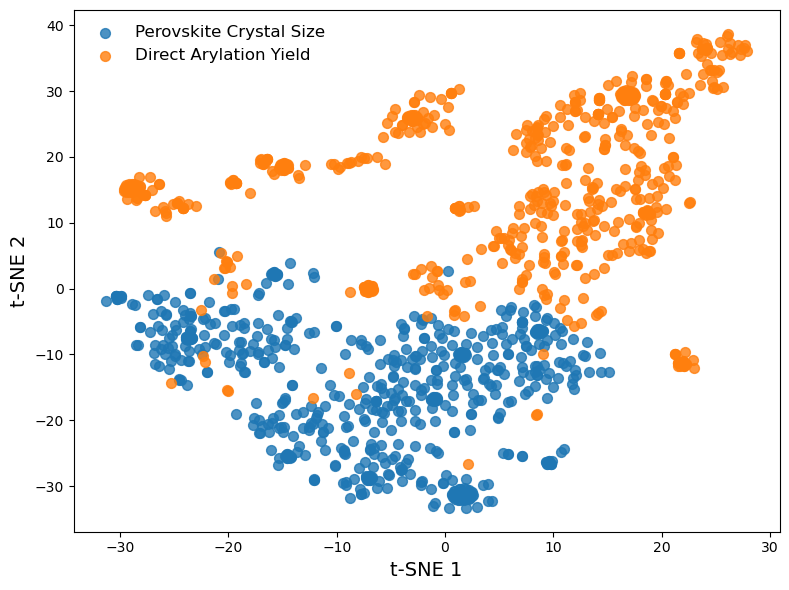

In [ ]:
# Chemical Space analysis
import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
from rdkit.Chem import AllChem
from jsonschema import draft3_format_checker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler

ABC_pvk = []
PSO_pvk = []
ABC_ary = []
PSO_ary = []

# 讀取 data1.csv 到 data10.csv
for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC_pvk.append(df)
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO_pvk.append(df)

for method in methods:
    if method == 'ABC':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            ABC_ary.append(df)
    if method =='PSO':
        for i in range(10):
            filename = f"/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/3_Make_New_Data_Predictor/{method}/round{i+1}/cycle5.csv"
            df = pd.read_csv(filename)
            PSO_ary.append(df)

# 合併成一個大 DataFrame
ABC_pvk = pd.concat(ABC_pvk, ignore_index=True)
ABC_ary = pd.concat(ABC_ary, ignore_index=True)


# 從SMILES生成Morgan fingerprints
pvkfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC_pvk['SMILES']]
aryfingerprints = [AllChem.GetHashedMorganFingerprint(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in ABC_ary['Ligand_SMILES']]

pvk_fp_array = np.array([list(fp) for fp in pvkfingerprints])
ary_fp_array = np.array([list(fp) for fp in aryfingerprints])

fp_array = np.concatenate((pvk_fp_array, ary_fp_array), axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=40)
tsne_results = tsne.fit_transform(fp_array)

# Normalize the t-SNE values
scaler = MinMaxScaler()
tsne_results_normalized = scaler.fit_transform(tsne_results)

# 建立分組標籤：前600為0，後600為1
labels = np.array([0]*600 + [1]*600)

# 繪圖（兩種顏色）
colors = ['#1f77b4', '#ff7f0e']  # 藍 / 橘
dataset = ['Perovskite Crystal Size', 'Direct Arylation Yield']
plt.figure(figsize=(8, 6))
for i in [0, 1]:
    mask = labels == i
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                color=colors[i], label=dataset[i], s=50, alpha=0.8)

plt.legend(frameon=False, fontsize = 12)
#plt.title('t-SNE of Big Array (Split Coloring)')
plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.tight_layout()
plt.show()

160                            CC(C)CC1CCCCC12C[NH+]=CN2
161                     Cc1ncsc1C1C[NH2+]C(=Nc2ccncc2)C1
162    CCc1onc(-c2ncnc3c2cnc2ncc(-c4ccnc(OCC(C)C)c4)n...
163                        CC(C)(C)OC1NC=[NH+]C1C1CCOCC1
164                                 CC1(C)CNCCNCCCNCCNC1
                             ...                        
355                   Cc1cc(O)nc2c1C(c1cncs1)Oc1ccccc1-2
356               Cc1ccnc(C=NN2c3ccccc3NC23CNC=[NH+]3)c1
357                      CC(C)N1CCNCCNC(CCN)c2cccc(n2)C1
358                             COC(=O)C1=CC(=O)C(C)N=C1
359               CCc1c(N2C(c3ccccc3)=Nc3ccccc3C2O)noc1C
Name: SMILES, Length: 200, dtype: object


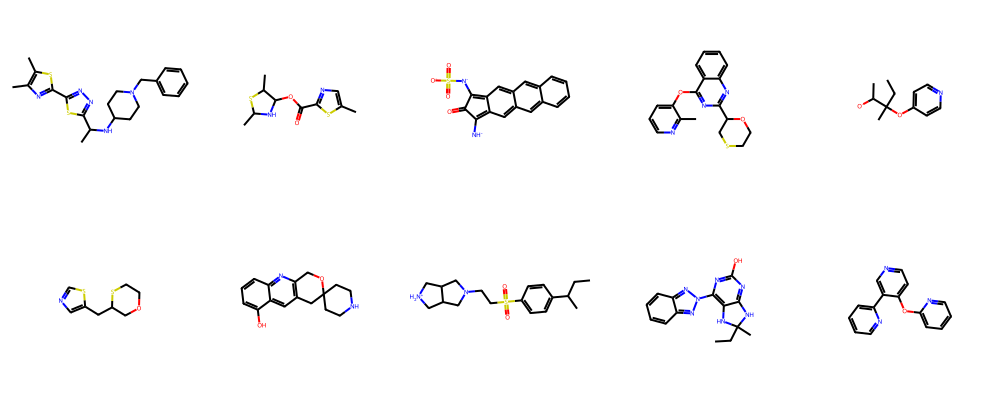

In [ ]:
# print the top 10 molecules
# Sort the DataFrame by the 'crystal_size' column in ascending order
from rdkit import Chem
from rdkit.Chem import Draw

data10 = pd.read_csv(data_path10)
data5 = pd.read_csv(data_path5)
data2 = pd.read_csv(data_path2)

data10 , data5, data2 = data10.iloc[160:],data5.iloc[160:],data2.iloc[160:]

print(data10['SMILES'])
data10_df_sorted = data10.sort_values(by='crystal_size', ascending=True)
data5_df_sorted = data5.sort_values(by='crystal_size', ascending=True)
data2_df_sorted = data2.sort_values(by='crystal_size', ascending=True)
mol10 = [Chem.MolFromSmiles(smiles) for smiles in data10_df_sorted['SMILES'].head(10)]
mol5 = [Chem.MolFromSmiles(smiles) for smiles in data5_df_sorted['SMILES'].head(10)]
mol2 = [Chem.MolFromSmiles(smiles) for smiles in data2_df_sorted['SMILES'].head(10)]

# Generate molecule images
img1 = Draw.MolsToGridImage(mol10, molsPerRow=5, subImgSize=(200, 200)) #, legends=data10_df_sorted['SMILES'])
img2 = Draw.MolsToGridImage(mol5, molsPerRow=5, subImgSize=(200, 200)) #, legends=data5_df_sorted['SMILES'])
img3 = Draw.MolsToGridImage(mol2, molsPerRow=5, subImgSize=(200, 200)) #, legends=data2_df_sorted['SMILES'])
img1
#img2
#img3

['c1ccc(-c2ccc(C3=NCCO3)nc2)nc1', 'Cc1ccnc(-c2cnc3sccc3c2)c1', 'Cc1ccnc(CNC2C=CCCC2)c1', 'CC(N)c1cccnc1-c1ccccn1', 'OCc1cccnc1-c1ccccn1', 'Cc1ccncc1-c1ccncc1', 'Cc1ccnc(COc2cc(C)n[nH]2)c1', 'Cc1c(C2CCCCC2)nc2ccccc2c1C', 'CCc1ccnc(C(=O)O)c1', 'Cc1cc2c(-c3cccnn3)ccnc2cc1[O-]', 'CC1CC=C2N=CC=C(C(C)N)C2O1', 'Cc1ccncc1Cc1nc([NH-])nc2ccsc12', 'Cc1cnc(CO)cc1C', 'Cc1ccnc2cncc(-c3cn[nH]c3)c12']


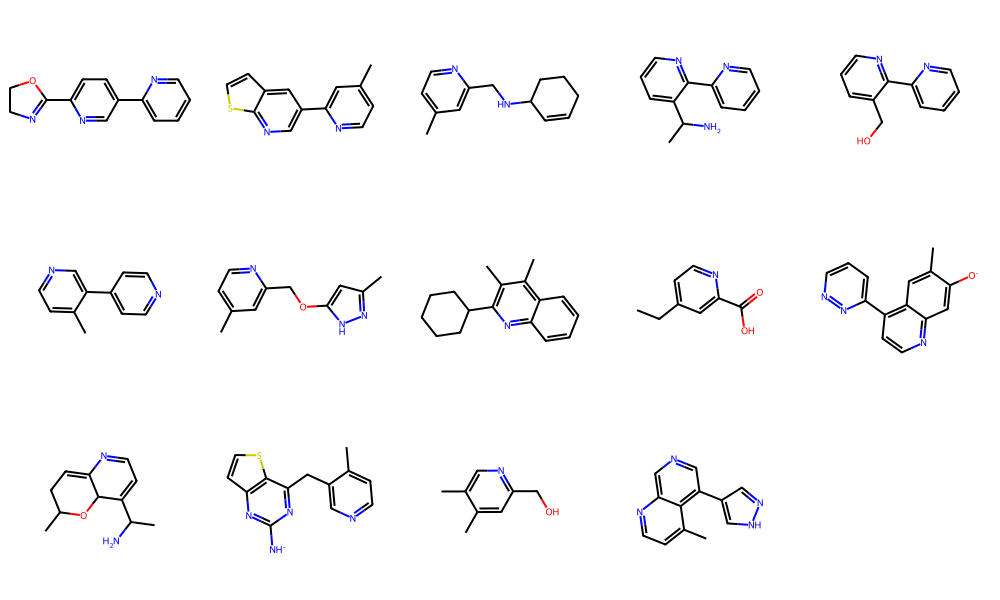

In [ ]:
# initial smiles
# print the top 10 molecules
# Sort the DataFrame by the 'crystal_size' column in ascending order
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

data10 = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/3_Make_New_Data_Predictor/ABC/cycle0.csv')

smiles = list(set(data10['SMILES'].tolist()))
print(smiles)
mol = [Chem.MolFromSmiles(smiles) for smiles in smiles]
img1 = Draw.MolsToGridImage(mol, molsPerRow=5, subImgSize=(200, 200))
img1